# AI Fashion Stylist

* Utilised **Cohere LLM** and **Weaviate VectorDB** to provide personalized fashion advice
* Analyses a user's request and matching them with relevant clothing items based on the domain knowledge from the Hugging Face dataset
* Generates a descriptive response detailing the recommended outfit, along with an example image created by **AI Horde**, offering a visual representation of the suggested ensemble

### Requirements

In [ ]:
%pip install datasets
%pip install cohere
%pip install weaviate-client
%pip install horde_sdk

In [3]:
import cohere
import weaviate
from datasets import load_dataset

cohere.__version__, weaviate.__version__

('5.5.4', '4.6.3')

### Authentication Setup

In [4]:
# import os

# os.environ["COHERE_APIKEY"] = "PUT_YOUR_COHERE_APIKEY_HERE"
# os.environ["WEAVIATE_URL"] = "PUT_YOUR_WEAVIATE_URL_HERE"
# os.environ["WEAVIATE_APIKEY"] = "PUT_YOUR_WEAVIATE_APIKEY_HERE"

### Connect to WCS

In [5]:
import os
from weaviate.auth import AuthApiKey
from dotenv import load_dotenv

load_dotenv()
client = weaviate.connect_to_wcs(
    cluster_url = os.environ["WEAVIATE_URL"],
    auth_credentials = AuthApiKey(os.environ["WEAVIATE_APIKEY"]),
    headers = {
        "X-Cohere-Api-Key": os.environ["COHERE_APIKEY"]
    }
)

### Load dataset

In [6]:
dataset = load_dataset("neuralwork/fashion-style-instruct")
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'completion', 'context'],
        num_rows: 3193
    })
})

In [12]:
import pprint
pprint.pp(dataset["train"][0])

{'input': "I'm a tall, athletic man with broad shoulders and a narrow waist. I "
          'prefer sharp, tailored suits that highlight my V-shaped torso.',
 'completion': 'Outfit Combination 1:\n'
               '- Top: Fitted white linen shirt\n'
               '- Bottom: Slim-fit beige chinos\n'
               '- Shoe: Brown leather loafers\n'
               '- Accessories: Brown woven belt, aviator sunglasses\n'
               '\n'
               'Outfit Combination 2:\n'
               '- Top: Light blue oxford button-down shirt\n'
               '- Bottom: Navy blue tailored trousers\n'
               '- Shoe: Tan leather brogues\n'
               '- Accessories: Navy blue patterned pocket square, silver '
               'wristwatch\n'
               '\n'
               'Outfit Combination 3:\n'
               '- Top: Light gray tailored blazer\n'
               '- Bottom: Dark wash denim jeans\n'
               '- Shoe: White canvas sneakers\n'
               '- Accessories: Bla

### Configure vectorizer

In [7]:
from weaviate.classes.config import Configure

In [ ]:
# client.collections.delete("Advisor")
client.collections.create(
    "Advisor",
    vectorizer_config = Configure.Vectorizer.text2vec_cohere(),
)

### Import Data

In [ ]:
advisor_data = client.collections.get("Advisor")

In [8]:
with advisor_data.batch.dynamic() as batch:
    for src_obj in dataset["train"]:
        weaviate_obj = {
            "traits": src_obj["input"],
            "combinations": src_obj["completion"],
            "occasion": src_obj["context"]
        }
        batch.add_object(properties = weaviate_obj)

len(dataset["train"]), len(advisor_data)

(3193, 3193)

### Query from DB

In [9]:
query = "I am a skinny guy attending a wedding ceremony"
response = advisor_data.query.hybrid(
    query = query,
    limit = 5
)

retrieve = ""
for obj in response.objects:
    retrieve += str(obj.properties["combinations"])

print(len(response.objects))


5


### Generate response

In [10]:
co = cohere.Client(os.environ["COHERE_APIKEY"])
response = co.chat(
    message = f"""DATA: {retrieve}\n\n
                Base on the DATA and the user's request: {query}, designe ONE outfit suggestion.
                Output Format Example:
                    - Top: Fitted navy blue button-down shirt.
                    - Bottom: Dark wash slim fit jeans.
                    - Shoes: Brown leather loafers.
                    - Accessories: A sleek silver watch and a brown leather belt.""",
    max_tokens = 250
)

In [13]:
pprint.pp(response.text)

('Here is an outfit suggestion for a skinny guy attending a wedding '
 'ceremony: \n'
 '\n'
 '- Top: Slim-fit light blue dress shirt, with the sleeves rolled up to just '
 'below the elbow. \n'
 '- Bottom: Dark navy tailored trousers with a subtle pinstripe pattern. \n'
 '- Shoes: Brown leather monk strap shoes with a cap toe design. \n'
 '- Accessories: A navy blue braided leather belt, and a silver watch with a '
 'blue face to match the shirt. \n'
 '\n'
 'This outfit provides a sleek and stylish look, balancing a skinny frame with '
 'well-fitted pieces. The light blue shirt adds a touch of color and '
 'freshness, while the dark navy trousers create a slimming effect. The brown '
 'leather accessories bring warmth and elegance to the ensemble. \n'
 '\n'
 "Remember to ensure the fit is just right, and you'll look fantastic at the "
 'wedding!')


### Visual suggestion

2024-06-04 17:08:38.473 | PROGRESS | horde_sdk.ai_horde_api.ai_horde_clients:image_generate_request:781 - Requesting 1 images.


2024-06-04 17:08:38.487 | DEBUG    | horde_sdk.ai_horde_api.ai_horde_clients:_do_request_with_check:648 - Submitting request: {'trusted_workers': False, 'slow_workers': True, 'workers': [], 'worker_blacklist': [], 'models': ['Deliberate'], 'dry_run': False, 'accept': <GenericAcceptTypes.json: 'application/json'>, 'client_agent': 'horde_sdk:v0.11.0:https://githib.com/haidra-org/horde-sdk', 'prompt': "Draw a model illustration base on the fashion styling advice Here is an outfit suggestion for a skinny guy attending a wedding ceremony: \n\n- Top: Slim-fit light blue dress shirt, with the sleeves rolled up to just below the elbow. \n- Bottom: Dark navy tailored trousers with a subtle pinstripe pattern. \n- Shoes: Brown leather monk strap shoes with a cap toe design. \n- Accessories: A navy blue braided leather belt, and a silver watch with a blue face to match the shirt. \n\nThis outfit provides a sleek and stylish look, balancing a skinny frame with well-fitted pieces. The light blue shi

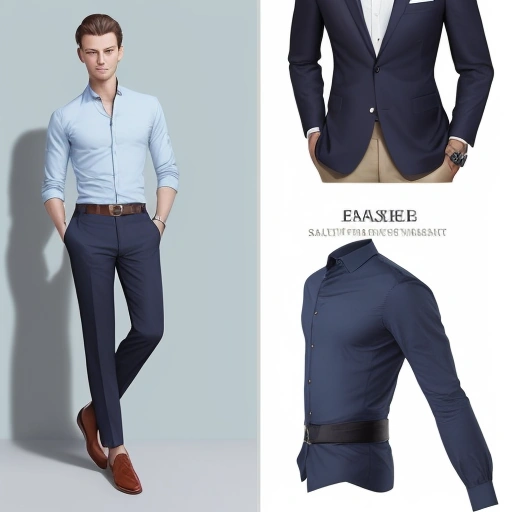

In [14]:
import PIL
from horde_sdk.ai_horde_api import AIHordeAPISimpleClient
from horde_sdk.ai_horde_api.apimodels import ImageGenerateAsyncRequest

image_generate_async_request = ImageGenerateAsyncRequest(
    apikey="0000000000",
    prompt=f"Draw a model illustration base on the fashion styling advice {response.text}",
    models=["Deliberate"]
)

simple_client = AIHordeAPISimpleClient()
status_response, job_id = simple_client.image_generate_request(image_generate_async_request)

image: PIL.Image.Image = simple_client.download_image_from_generation(status_response.generations[0])
image

### Close Client

In [15]:
client.close()